# Detecting Anomalous Streams using Signature Variance
## Marine Vessel Traffic Data

In [1]:
import itertools
import os.path
import sys
import time
import zipfile

import iisignature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.ensemble
import sklearn.model_selection
import sklearn.svm
import sklearn.utils

sys.path.insert(0, os.path.join('..', empirical-outliers'))
import variance
sys.path.insert(0, os.path.join('..', 'common'))
import evaluation
import util

In [2]:
%matplotlib inline
 
import IPython.display
IPython.display.set_matplotlib_formats('png', 'pdf')

In [3]:
np.random.seed(0)

In [4]:
t0 = time.time()

Download and extract dataset, if it does not already exist:

In [5]:
DATASET_PATH = 'AIS_2017_01_Zone17.csv'
ZIP_URL = 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2017/AIS_2017_01_Zone17.zip'
ZIP_PATH = 'AIS_2017_01_Zone17.zip'

if not os.path.exists(DATASET_PATH) and not os.path.exists(ZIP_PATH):
    try:
        util.download(ZIP_URL, ZIP_PATH)

        # Extract dataset and write to CSV file
        with zipfile.ZipFile(ZIP_PATH) as zf:
            with zf.open([s for s in zf.namelist() if ".csv" in s][0]) as csv_in:
                with open(DATASET_PATH, 'wb') as csv_out:
                    csv_out.write(csv_in.read())               
    except:
        if os.path.exists(DATASET_PATH):
            os.remove(DATASET_PATH)
        raise
    finally:
        if os.path.exists(ZIP_PATH):
            os.remove(ZIP_PATH)

In this analysis, we will group vessels by their MMSI identifier (MMSI column). For each vessel, we will consider its latitude/longitude position (LAT, LON columns) ordered by timestamp (BaseDateTime column). In addition, we will group vessels by their length (Length column). For exploratory purposes, we will also examine the Status column. Read in dataset, convert to timestamps, and sort by timestamp:

In [6]:
ais_df = pd.read_csv(DATASET_PATH,
                     usecols=['MMSI', 'LAT', 'LON', 'BaseDateTime', 'Length', 'Status'], dtype={'MMSI': str})
ais_df['BaseDateTime'] = pd.to_datetime(ais_df['BaseDateTime'])
ais_df.sort_values(by='BaseDateTime', inplace=True, ignore_index=True)

In [7]:
print('Number of records: {}'.format(len(ais_df)))
print('Number of distinct MMSI values: {}'.format(len(ais_df['MMSI'].unique())))

Number of records: 31884021
Number of distinct MMSI values: 6282


The MMSI is a 9-digit number which may be used to identify ships as well as other objects, such as search-and-rescue aircraft (see https://www.itu.int/rec/R-REC-M.585/en). We restrict ourselves to data points for which the MMSI field contains a 9-digit number:

In [8]:
ais_df = ais_df[ais_df['MMSI'].apply(lambda mmsi: len(mmsi) == 9)]

Summarise the BaseDateTime and Length fields: 

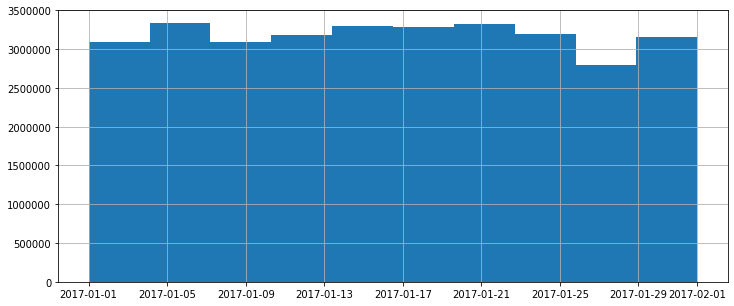

In [9]:
ais_df['BaseDateTime'].hist(figsize=(12, 5))

In [10]:
ais_df['Length'].describe()

count    2.672744e+07
mean     5.755111e+01
std      7.209671e+01
min      0.000000e+00
25%      1.951000e+01
50%      2.835000e+01
75%      4.620000e+01
max      3.621200e+02
Name: Length, dtype: float64

We observe no unusual timestamp values. However, the Length value should not be zero. We mark such data as missing:

In [11]:
ais_df['Length'].replace(to_replace=0.0, value=np.nan, inplace=True)

Obtain missing value counts for each of the columns:

In [12]:
ais_df.isnull().sum()

MMSI                  0
BaseDateTime          0
LAT                   0
LON                   0
Status          9592172
Length          5083609
dtype: int64

Discard those vessels with any missing Length data:

In [13]:
ais_df = ais_df.groupby('MMSI').filter(lambda vessel: vessel['Length'].notnull().all())

For each vessel, verify that its recorded length does not vary across data points.

In [14]:
assert(ais_df.groupby('MMSI').apply(lambda vessel: len(np.unique(vessel['Length'])) == 1).all())

Plot a histogram of possible navigation status values:

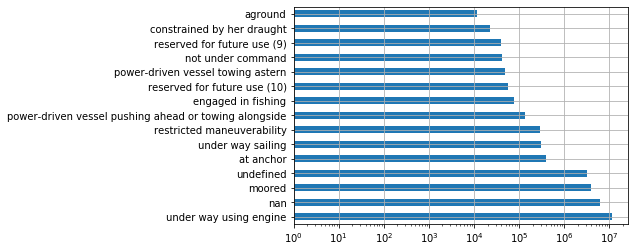

In [15]:
ais_df['Status'].value_counts(dropna=False).plot(kind='barh', log=True, grid=True)
del ais_df['Status']

According to the histogram, data points most frequently have the status value 'under way using engine'. 
However, the third-most frequently status value is 'moored'. We will therefore attempt to compress our data by retaining only those data points which represent a change in successively recorded position exceeding a distance threshold of 10 metres. (This processing step also helps ensure that subsequent estimates of path lengths are not inordinately influenced by jitter due to location measurement imprecision.)

In [16]:
ais_by_vessel = ais_df.groupby('MMSI').agg({'BaseDateTime' : lambda timestamps : timestamps.tolist(),
                                            'LAT' : lambda lats : lats.tolist(), 'LON' : lambda lons: lons.tolist(),
                                            'Length': lambda lengths: lengths.iloc[0]})
ais_by_vessel.sort_values(by='Length', inplace=True)

In [17]:
EARTH_RADIUS__M = 6371E3
def haversine_distance__m(lat1__deg, lon1__deg, lat2__deg, lon2__deg):
    lat1 = np.deg2rad(lat1__deg)
    lon1 = np.deg2rad(lon1__deg)
    lat2 = np.deg2rad(lat2__deg)
    lon2 = np.deg2rad(lon2__deg)

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = (np.sin(dlat / 2)**2) + np.cos(lat1) * np.cos(lat2) * (np.sin(dlon/2)**2)

    return 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)) * EARTH_RADIUS__M

In [18]:
def compress_stream(vessel, distance_threshold__m=10):
    lats__deg = vessel['LAT']
    lons__deg = vessel['LON']
    timestamps = vessel['BaseDateTime']
    
    significant_lats__deg = []
    significant_lons__deg = []
    significant_timestamps = []
    distance_between_positions__m = []

    for lat__deg, lon__deg, timestamp in zip(lats__deg, lons__deg, timestamps):
        if len(significant_lats__deg) == 0:
            significant_lats__deg.append(lat__deg)
            significant_lons__deg.append(lon__deg)
            distance_between_positions__m.append(0)
            significant_timestamps.append(timestamp)
            continue

        distance__m = haversine_distance__m(lat__deg, lon__deg,
                                            significant_lats__deg[-1], significant_lons__deg[-1])
        
        if distance__m > distance_threshold__m:
            significant_lats__deg.append(lat__deg)
            significant_lons__deg.append(lon__deg)
            significant_timestamps.append(timestamp)
            distance_between_positions__m.append(distance__m)

    vessel['LAT'] = significant_lats__deg
    vessel['LON'] = significant_lons__deg
    vessel['BaseDateTime'] = significant_timestamps
    vessel['DISTANCE_BETWEEN_POSITIONS'] = distance_between_positions__m

    return vessel

print('Total number of data points before compression: {}'.format(
      ais_by_vessel['LAT'].apply(lambda lat: len(lat)).sum()))

ais_by_vessel = ais_by_vessel.apply(lambda vessel: compress_stream(vessel), axis=1)

print('Total number of data points after compression: {}'.format(
      ais_by_vessel['LAT'].apply(lambda lat: len(lat)).sum()))

Total number of data points before compression: 26676568
Total number of data points after compression: 7869140


In [19]:
ais_by_vessel = {'Original': ais_by_vessel.copy(), 'Filtered': ais_by_vessel}

Retain only those vessels for which the haversine distance between initial and final positions corresponds to a distance greater than 5km:

In [20]:
ais_by_vessel['Filtered']['DIAGONAL_LENGTH'] = \
    ais_by_vessel['Filtered'].apply(lambda vessel: haversine_distance__m(min(vessel['LAT']), min(vessel['LON']),
                                                                         max(vessel['LAT']), max(vessel['LON'])),
                                    axis=1)

ais_by_vessel['Filtered'] = ais_by_vessel['Filtered'][ais_by_vessel['Filtered']['DIAGONAL_LENGTH'] > 5E3]

In [21]:
ais_by_vessel['Filtered']['TOTAL_DISTANCE_TRAVELLED'] = \
    ais_by_vessel['Filtered']['DISTANCE_BETWEEN_POSITIONS'].apply(lambda distances: sum(distances))

Plot sample of paths, ordered by vessel length:

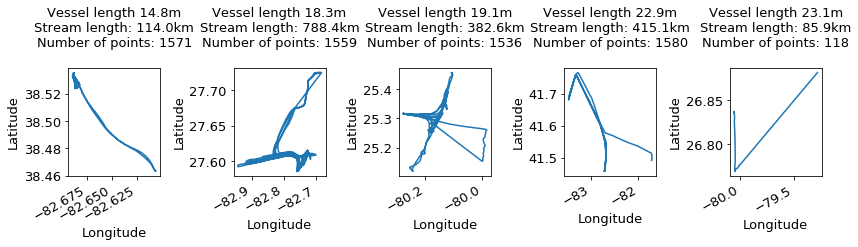

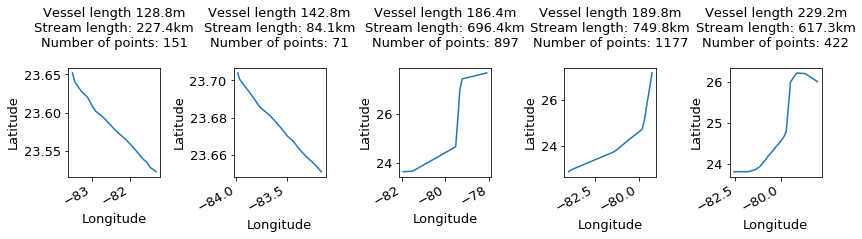

In [22]:
def plot_paths(df, fontsize=13):
    n_subplots_per_row = 5 
    n_rows = int(np.ceil(len(df) / n_subplots_per_row))
    fig, ax = plt.subplots(n_rows, n_subplots_per_row, figsize=(13.5, n_rows * 2.0), squeeze=True)
    for (_, vessel), ax in zip(df.iterrows(), ax.flatten()):
        ax.plot(vessel['LON'], vessel['LAT'])
        ax.set_title('Vessel length {:2.1f}m\n'
                     'Stream length: {:2.1f}km\n'
                     'Number of points: {}\n'.format(vessel['Length'],
                                                     vessel['TOTAL_DISTANCE_TRAVELLED'] / 1E3,
                                                     len(vessel['LAT'])),
                     fontsize=fontsize)
        ax.set_xlabel('Longitude', fontsize=fontsize)
        ax.set_ylabel('Latitude', fontsize=fontsize)
        ax.tick_params(axis='both', which='major', labelsize=fontsize)
        ax.tick_params(axis='both', which='minor', labelsize=fontsize)
        plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

    plt.subplots_adjust(wspace=0.8)
    plt.show()
    
    return fig

fig = plot_paths(ais_by_vessel['Filtered'][ais_by_vessel['Filtered']['Length'] < 50.0].sample(n=5, random_state=1).sort_values(by='Length'))
fig.savefig('paths_short_vessel.pdf', bbox_inches='tight')
fig = plot_paths(ais_by_vessel['Filtered'][ais_by_vessel['Filtered']['Length'] > 100.0].sample(n=5, random_state=2).sort_values(by='Length'))
fig.savefig('paths_long_vessel.pdf', bbox_inches='tight')

Split streams into sub-streams using alternative thresholds (4km, 8km, 16km, 32km) and store results in pickle files:

In [23]:
def split_lat_lon_stream(vessel, distance_threshold__m=4E3):
    split_points = [0]
    lats = vessel['LAT']
    lons = vessel['LON']
    for i in range(1, len(lats)):
        distance = haversine_distance__m(lats[split_points[-1]], lons[split_points[-1]],
                                         lats[i], lons[i])

        if distance > distance_threshold__m:
            split_points.append(i)
    
    for key in 'LAT', 'LON', 'DISTANCE_BETWEEN_POSITIONS', 'BaseDateTime':
        vessel[key] = [np.array(vessel[key])[split_points[i]:(split_points[i+1] + 1)].tolist()
                       for i in range(len(split_points) - 1)]
        
    # Ensure correct accumulation of distance across sub-streams
    vessel['DISTANCE_BETWEEN_POSITIONS'] = [[0] + distances[1:] for distances in vessel['DISTANCE_BETWEEN_POSITIONS']]
    vessel['TOTAL_DISTANCE_TRAVELLED'] = [sum(distances) for distances in vessel['DISTANCE_BETWEEN_POSITIONS']]
    
    return vessel

def split_data(ais_by_vessel, distance_threshold__m=4E3):
    ais_by_vessel_split = ais_by_vessel.apply(lambda vessel: split_lat_lon_stream(vessel, distance_threshold__m),
                                              axis=1).agg({'LAT' : lambda lats: pd.Series(lats, dtype='object'),
                                                           'LON' : lambda lons: pd.Series(lons, dtype='object'),
                                                           'Length': lambda length: pd.Series(length, dtype='object'),
                                                           'BaseDateTime': lambda timestamps: pd.Series(timestamps, dtype='object'),
                                                           'DISTANCE_BETWEEN_POSITIONS': lambda distances: pd.Series(distances, dtype='object'),
                                                           'TOTAL_DISTANCE_TRAVELLED': lambda distance: pd.Series(distance, dtype='object')
                                                          }).stack()
    
    # Ensure that vessel length field is populated for each sub-stream
    ais_by_vessel_split['Length'].fillna(method='ffill', inplace=True)
    
    return ais_by_vessel_split


SUBSTREAMS_PATH = 'AIS_2017_01_Zone17_substreams_GRANULARITY.pkl'
DISTANCE_THRESHOLDS = (4000, 8000, 16000, 32000)
for distance_threshold in DISTANCE_THRESHOLDS:
    print('Extracting sub-streams using distance threshold={}'.format(distance_threshold))
    # Split into substreams, dropping empty records for which is was not possible to obtain any
    # substreams of the desired length:
    ais_by_vessel_split = split_data(ais_by_vessel['Filtered'], distance_threshold).dropna()
    ais_by_vessel_split.to_pickle(SUBSTREAMS_PATH.replace('GRANULARITY', str(distance_threshold)))

Extracting sub-streams using distance threshold=4000
Extracting sub-streams using distance threshold=8000
Extracting sub-streams using distance threshold=16000
Extracting sub-streams using distance threshold=32000


Read in pickle files:

In [24]:
ais_by_vessel_split = {}
for distance_threshold in DISTANCE_THRESHOLDS:
    ais_by_vessel_split[distance_threshold] = \
        pd.read_pickle(SUBSTREAMS_PATH.replace('GRANULARITY', str(distance_threshold)))

For each sub-stream, compute maximum distance between successive points. Plot histogram of log-transformed data:

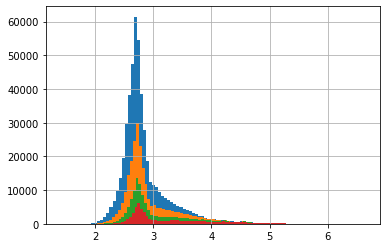

In [25]:
for distance_threshold in ais_by_vessel_split.keys():
    ais_by_vessel_split[distance_threshold]['DISTANCE_BETWEEN_POSITIONS'].apply(np.max).apply(np.log10).hist(bins=100)

Retain those sub-streams for which the maximum distance between successively recorded positions is less than 1km:

In [26]:
for distance_threshold in ais_by_vessel_split.keys():
    ais_by_vessel_split[distance_threshold] = \
        ais_by_vessel_split[distance_threshold][ais_by_vessel_split[distance_threshold]['DISTANCE_BETWEEN_POSITIONS'].apply(np.max) < 1E3]

For subsequent use, convert timestamps to seconds elapsed since the Unix epoch:

In [27]:
for distance_threshold in ais_by_vessel_split.keys():
    ais_by_vessel_split[distance_threshold]['BaseDateTime'] = \
        ais_by_vessel_split[distance_threshold]['BaseDateTime'].apply(lambda timestamps: [int(t.asm8)/1E9 for t in timestamps])

Plot histogram of log-transformed point counts that we obtain for each sub-stream:

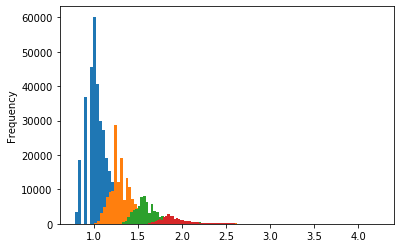

In [28]:
for distance_threshold in ais_by_vessel_split.keys():
        ais_by_vessel_split[distance_threshold]['DISTANCE_BETWEEN_POSITIONS'].apply(len).apply(np.log10).plot(kind='hist', bins=100)

Plot sample of paths, ordered by vessel length:

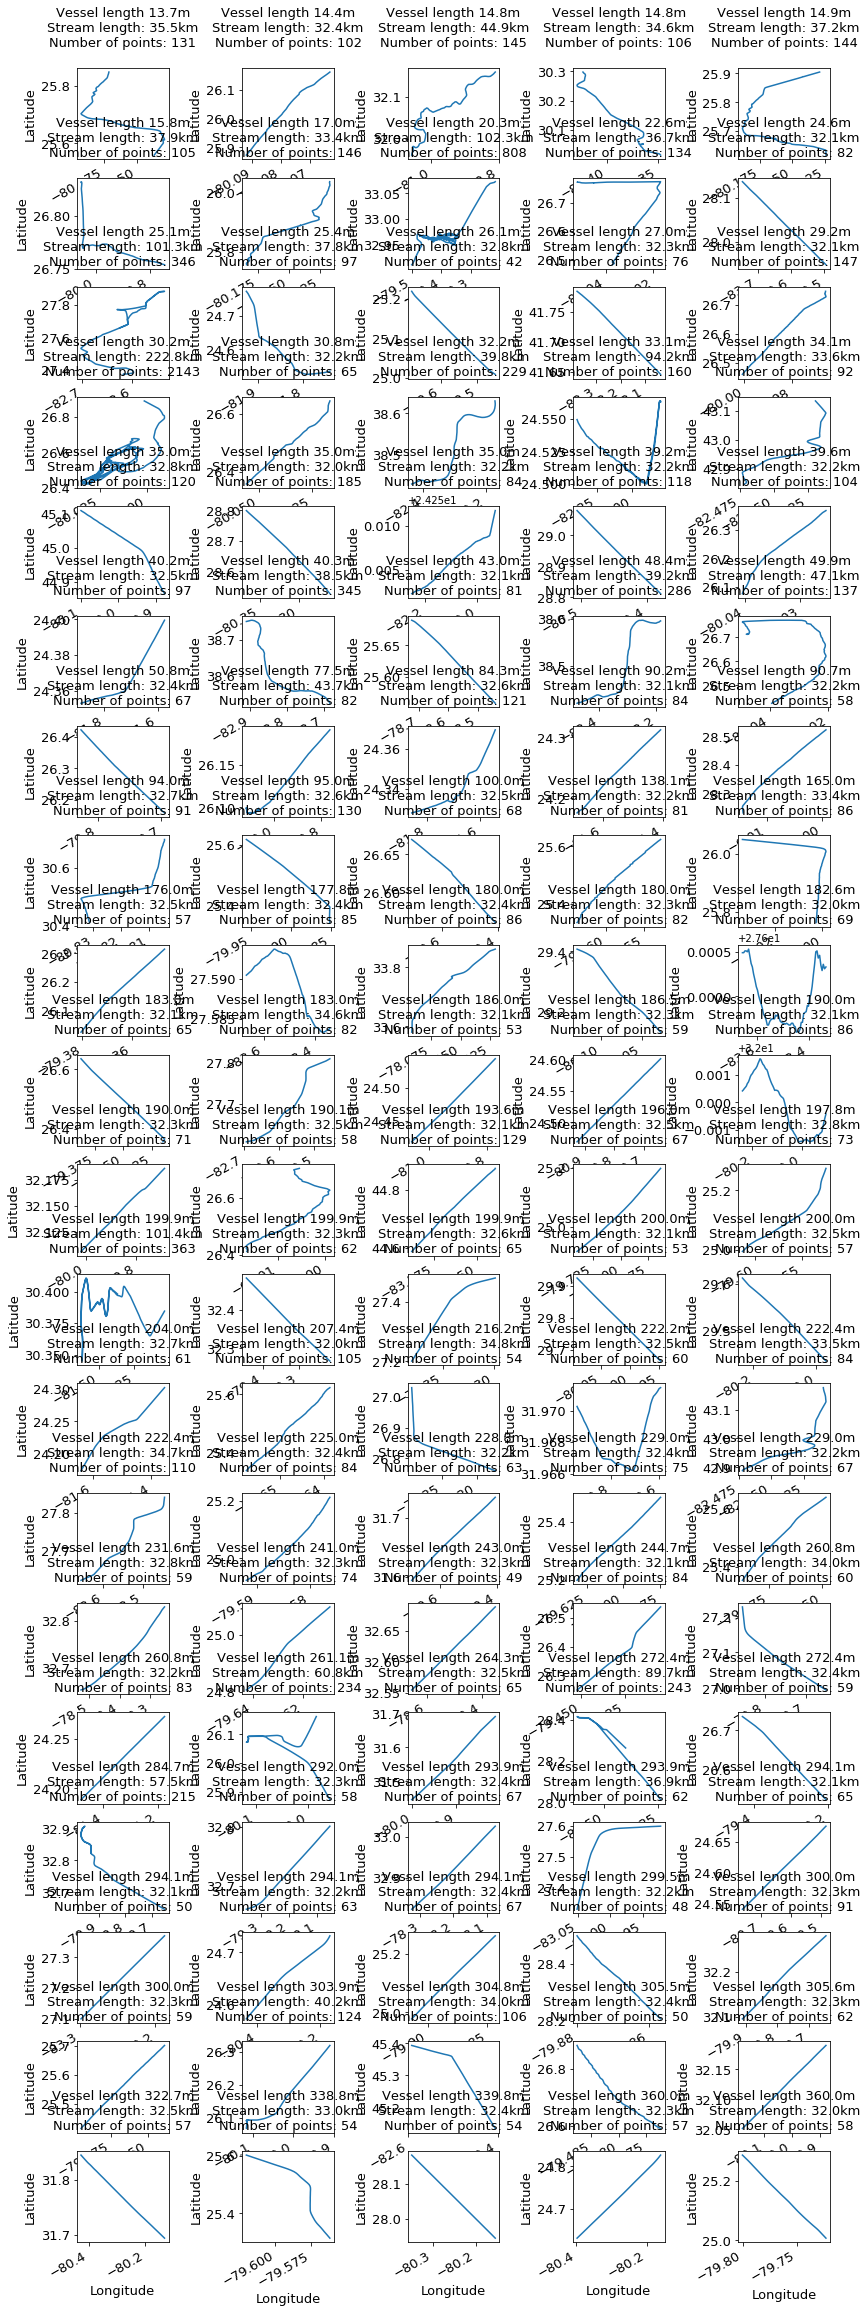

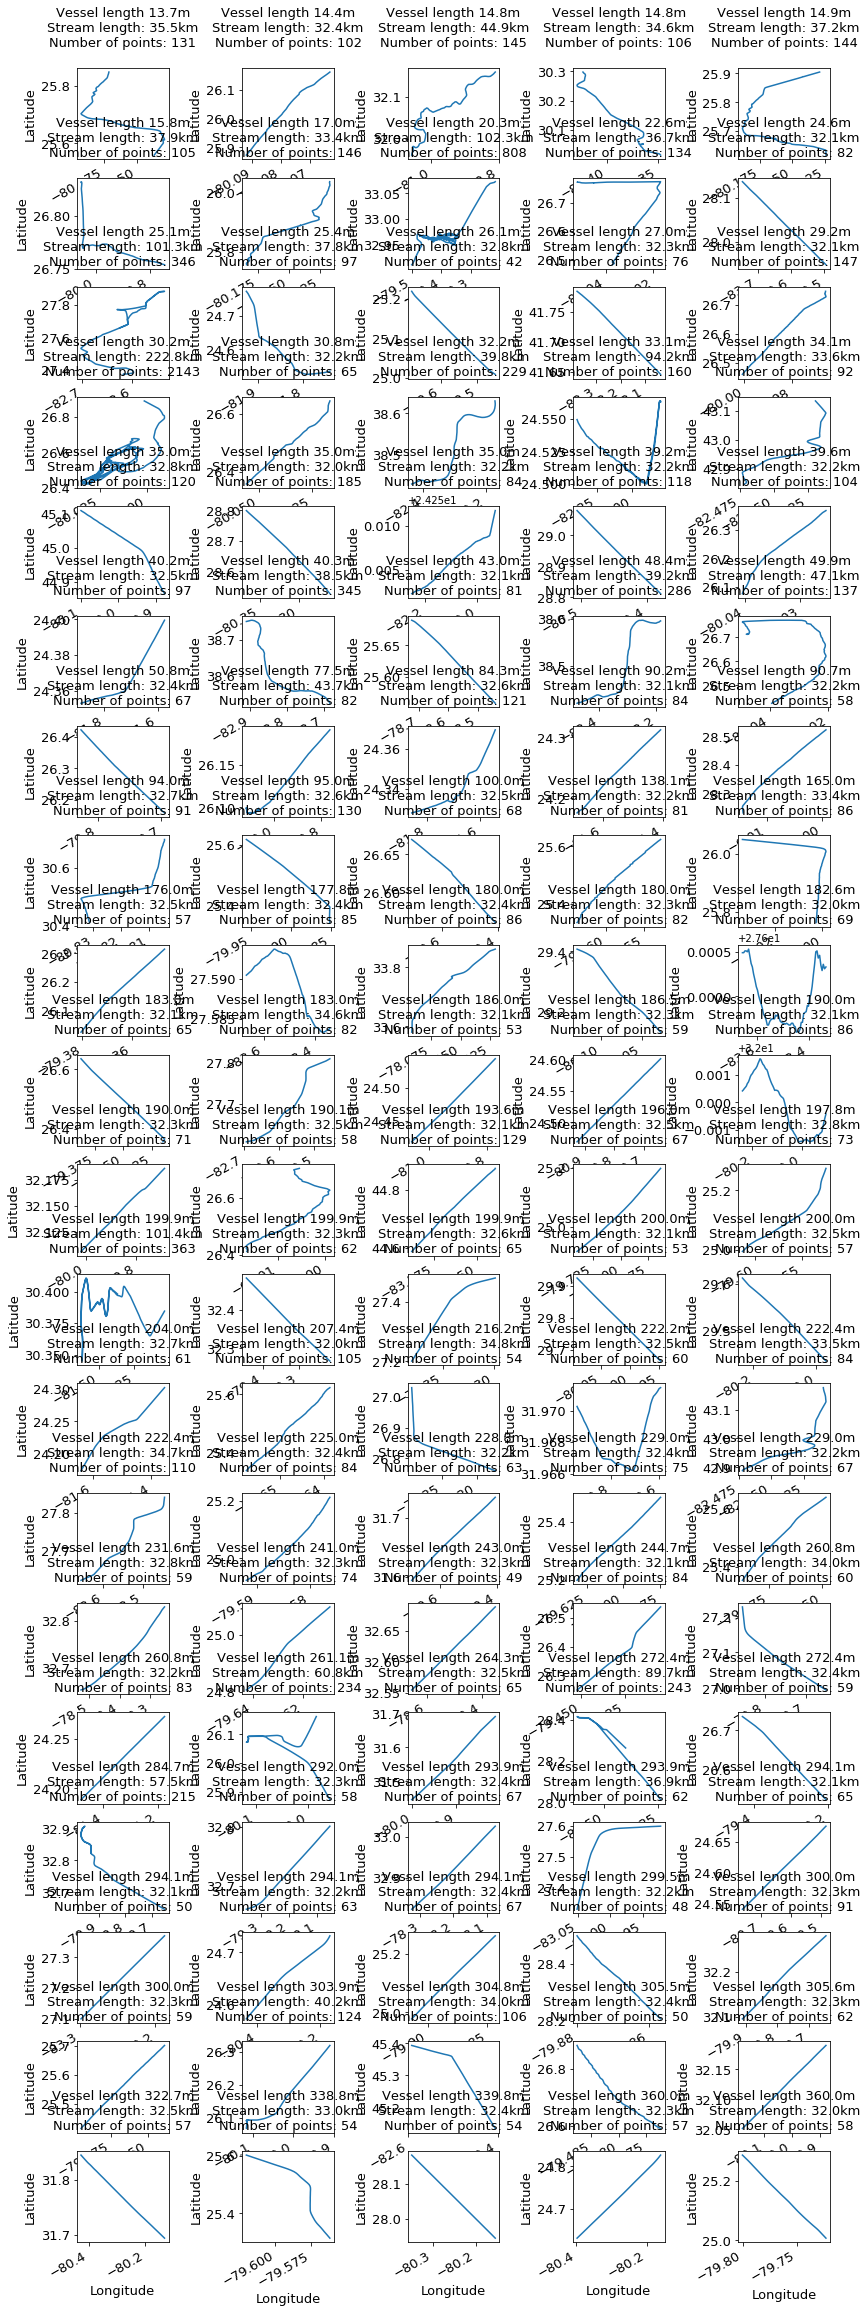

In [29]:
plot_paths(ais_by_vessel_split[32000].sample(n=100, random_state=0).sort_values(by='Length'))

For each sub-stream, compute the sub-stream's weighting factor as the reciprocal of the total number of sub-streams in the vessel's stream.
When quantifying performance, we will use weighting factors in to ensure that we do not emphasise any vessels with very large numbers of sub-streams relative to other vessels.

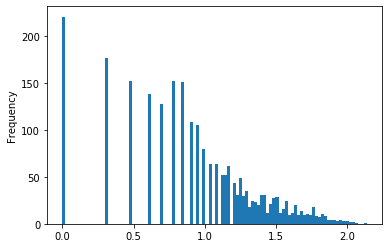

In [30]:
ais_by_vessel_split[32000].groupby('MMSI').count()['LAT'].apply(np.log10).plot(kind='hist', bins=100)

In [31]:
for distance_threshold in ais_by_vessel_split.keys():
    ais_by_vessel_split[distance_threshold]['N_SUBSTREAMS'] = \
        ais_by_vessel_split[distance_threshold].groupby('MMSI')['LAT'].count().reindex(ais_by_vessel_split[distance_threshold].index, level=0)

In [32]:
for distance_threshold in ais_by_vessel_split.keys():
    ais_by_vessel_split[distance_threshold]['SUBSTREAM_WEIGHT'] = \
        1 / ais_by_vessel_split[distance_threshold]['N_SUBSTREAMS']

Partition data into training inlier, testing inlier and testing outlier subsets.
Note that although the number of sub-streams may vary, we ensure that the set of vessels remains consistent across considered values of the distance_threshold parameter:

In [33]:
cooccurring_mmsis = []
for data_subset in ais_by_vessel_split.values():
    cooccurring_mmsis += [set(data_subset.reset_index()['MMSI'].unique())]
cooccurring_mmsis = sorted(set.intersection(*cooccurring_mmsis))
cooccurring_ais_by_vessel = ais_by_vessel['Filtered'].loc[cooccurring_mmsis]

inlier_mmsis = list(cooccurring_ais_by_vessel[cooccurring_ais_by_vessel['Length'] > 100.0].reset_index()['MMSI'].unique())
outlier_mmsis = list(cooccurring_ais_by_vessel[cooccurring_ais_by_vessel['Length'] <= 50].reset_index()['MMSI'].unique())

inlier_mmsis_train, inlier_mmsis_test = \
    sklearn.model_selection.train_test_split(inlier_mmsis, test_size=0.5, random_state=0)

Print number of sub-streams in each subset:

In [34]:
for distance_threshold in ais_by_vessel_split.keys():
    for data_subset, label in zip((inlier_mmsis_train, inlier_mmsis_test, outlier_mmsis),
                                  ('training inliers', 'testing inliers', 'testing outliers')):
        count = len(ais_by_vessel_split[distance_threshold].loc[data_subset])
        weighted_count = sum(ais_by_vessel_split[distance_threshold].loc[data_subset]['SUBSTREAM_WEIGHT'])
        print('distance_threshold={}, {}: {} sub-streams, weighted count (=number of vessels) {:.2f}'.format(distance_threshold, label, count, weighted_count))

distance_threshold=4000, training inliers: 109662 sub-streams, weighted count (=number of vessels) 607.00
distance_threshold=4000, testing inliers: 108778 sub-streams, weighted count (=number of vessels) 607.00
distance_threshold=4000, testing outliers: 123237 sub-streams, weighted count (=number of vessels) 997.00
distance_threshold=8000, training inliers: 52668 sub-streams, weighted count (=number of vessels) 607.00
distance_threshold=8000, testing inliers: 52641 sub-streams, weighted count (=number of vessels) 607.00
distance_threshold=8000, testing outliers: 54796 sub-streams, weighted count (=number of vessels) 997.00
distance_threshold=16000, training inliers: 24230 sub-streams, weighted count (=number of vessels) 607.00
distance_threshold=16000, testing inliers: 24525 sub-streams, weighted count (=number of vessels) 607.00
distance_threshold=16000, testing outliers: 22756 sub-streams, weighted count (=number of vessels) 997.00
distance_threshold=32000, training inliers: 10611 su

Define a function which takes an input stream and transforms it as specified.
Define a function for min-max scaling.

In [35]:
def get_stream(vessel, include_time_diffs=False, lead_lag_transform=False, invisibility_transform=False):
    stream = np.column_stack((vessel['LAT'], vessel['LON']))
    
    if include_time_diffs:
        stream = np.column_stack((stream, np.append(0, np.diff(vessel['BaseDateTime']))))
        
    if lead_lag_transform:
        stream = np.repeat(stream, 2, axis=0)
        stream = np.column_stack((stream[1:, :], stream[:-1, :]))
        
    if invisibility_transform:
        stream = np.vstack(((stream, stream[-1], np.zeros_like(stream[-1]))))
        stream = np.column_stack((stream, np.append(np.ones(stream.shape[0]-2), [0, 0])))
    
    return stream

def normalise(streams, minimum=None, maximum=None):
    if minimum is None and maximum is None:
        streams_stacked = np.vstack(streams)
        minimum = np.min(streams_stacked, axis=0)
        maximum = np.max(streams_stacked, axis=0)

    streams = [(stream - minimum) / (maximum - minimum) for stream in streams]

    return streams, minimum, maximum

For each considered value of distance_threshold and for each data subset, obtain a weighted sample of 5000 sub-streams (based on sampling with replacement). Compute stream signatures based on truncation level 3 and determine variance of testing exemplars with respect to training corpus:

In [36]:
def compute_stream_signature_variance(streams_by_inlier_vessel_train, streams_by_inlier_vessel_test,
                                    streams_by_outlier_vessel, distance_threshold, signature_order=3):
    streams_by_inlier_vessel_train, minimum, maximum = normalise(streams_by_inlier_vessel_train)
    streams_by_inlier_vessel_test, *_ = normalise(streams_by_inlier_vessel_test, minimum, maximum)
    streams_by_outlier_vessel, *_ = normalise(sklearn.utils.shuffle(streams_by_outlier_vessel, random_state=0),
                                            minimum, maximum)

    variance_inliers = \
        np.array(variance.variance(streams_by_inlier_vessel_test, streams_by_inlier_vessel_train, signature_order))
    variance_outliers = \
        np.array(variance.variance(streams_by_outlier_vessel, streams_by_inlier_vessel_train, signature_order))
    
    return variance_inliers, variance_outliers

Define a function which computes the variance of testing subsets:

In [37]:
def evaluate(ais_by_vessel_split, inlier_mmsis_train, inlier_mmsis_test, outlier_mmsis,
             distance_threshold=32000, n_samples=5000,
             outlier_detection_method=compute_stream_signature_variance):
    
    variance_inliers = {}
    variance_outliers = {}
    
    ais_by_vessel_split = ais_by_vessel_split[distance_threshold]
    
    def sample_data(ais_by_vessel_split, random_state):
        return ais_by_vessel_split.sample(n=n_samples, weights='SUBSTREAM_WEIGHT', replace=True,
                                          random_state=random_state)
    
    ais_by_inlier_vessel_train = sample_data(ais_by_vessel_split.loc[inlier_mmsis_train], random_state=1)
    ais_by_inlier_vessel_test = sample_data(ais_by_vessel_split.loc[inlier_mmsis_test], random_state=2)
    ais_by_outlier_vessel = sample_data(ais_by_vessel_split.loc[outlier_mmsis], random_state=3)
 
    for param_combination in itertools.product(*([[False, True]] * 3)):
        key = 'Lead/Lag={}, Time={}, Inv. Reset={}'.format(*param_combination)
        stream_function = lambda vessel: get_stream(vessel, invisibility_transform=param_combination[0],
                                                    include_time_diffs=param_combination[1],
                                                    lead_lag_transform=param_combination[2])

        streams_by_inlier_vessel_train = ais_by_inlier_vessel_train.apply(stream_function, axis=1).to_list()
        streams_by_inlier_vessel_test = ais_by_inlier_vessel_test.apply(stream_function, axis=1).to_list()
        streams_by_outlier_vessel = ais_by_outlier_vessel.apply(stream_function, axis=1).to_list()
        
        variance_inliers[key], variance_outliers[key] = outlier_detection_method(streams_by_inlier_vessel_train,
                                                                                 streams_by_inlier_vessel_test,
                                                                                 streams_by_outlier_vessel,
                                                                                 distance_threshold)        
    return variance_inliers, variance_outliers


Define a function which evaluates across a range of distance thresholds:

In [38]:
%%time
def evaluate_across_hyperparams(outlier_detection_method=compute_stream_signature_variance):
    variance_inliers_vs_hyperparams = {}
    variance_outliers_vs_hyperparams = {}

    for distance_threshold in ais_by_vessel_split.keys():
        key = 'Substreams using distance threshold {}m'.format(distance_threshold)
        variance_inliers_vs_hyperparams[key], variance_outliers_vs_hyperparams[key] = \
            evaluate(ais_by_vessel_split, inlier_mmsis_train, inlier_mmsis_test, outlier_mmsis, distance_threshold,
                     outlier_detection_method=outlier_detection_method)

    return variance_inliers_vs_hyperparams, variance_outliers_vs_hyperparams

variance_inliers_vs_hyperparams, variance_outliers_vs_hyperparams = evaluate_across_hyperparams()

Building shuffle matrix: 100%|██████████| 15/15 [00:00<00:00, 2316.27it/s]

Preparing...



Computing variances:   0%|          | 1/5000 [00:00<10:24,  8.01it/s]

Done.


Computing signatures:   6%|▌         | 292/5000 [00:00<00:03, 1489.24it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 85/85 [00:00<00:00, 270.37it/s]


Done.


Computing signatures:  24%|██▎       | 1180/5000 [00:00<00:00, 11798.35it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 40/40 [00:00<00:00, 588.89it/s]


Done.


Computing signatures:   0%|          | 21/5000 [00:00<00:25, 198.98it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 259/259 [00:03<00:00, 82.11it/s]


Done.


Computing signatures:  19%|█▊        | 931/5000 [00:00<00:00, 9307.66it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 40/40 [00:00<00:00, 582.74it/s]


Done.


Computing signatures:   0%|          | 22/5000 [00:00<00:22, 218.59it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 156/156 [00:01<00:00, 151.95it/s]


Done.


Computing signatures:   4%|▍         | 208/5000 [00:00<00:04, 1074.15it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 85/85 [00:00<00:00, 285.64it/s]


Done.


Computing signatures:   0%|          | 8/5000 [00:00<01:04, 77.82it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 400/400 [00:07<00:00, 54.27it/s]


Done.


Computing signatures:  15%|█▌        | 762/5000 [00:00<00:00, 7596.01it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 15/15 [00:00<00:00, 2487.13it/s]


Done.


Computing signatures:   2%|▏         | 115/5000 [00:00<00:04, 1103.90it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 85/85 [00:00<00:00, 303.04it/s]


Done.


Computing signatures:  33%|███▎      | 1642/5000 [00:00<00:00, 8234.91it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 40/40 [00:00<00:00, 727.14it/s]


Done.


Computing signatures:   0%|          | 13/5000 [00:00<00:40, 122.12it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 259/259 [00:03<00:00, 84.75it/s]


Done.


Computing signatures:  17%|█▋        | 839/5000 [00:00<00:00, 8387.83it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 40/40 [00:00<00:00, 695.86it/s]


Done.


Computing signatures:   1%|          | 37/5000 [00:00<00:13, 359.75it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 156/156 [00:01<00:00, 155.19it/s]


Done.


Computing signatures:   8%|▊         | 386/5000 [00:00<00:02, 1904.60it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 85/85 [00:00<00:00, 268.82it/s]


Done.


Computing signatures:   0%|          | 6/5000 [00:00<01:34, 53.11it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 400/400 [00:07<00:00, 52.25it/s]


Done.


Computing signatures:  54%|█████▎    | 2687/5000 [00:00<00:00, 8987.05it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 15/15 [00:00<00:00, 2273.34it/s]


Done.


Computing signatures:   2%|▏         | 82/5000 [00:00<00:13, 354.15it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 85/85 [00:00<00:00, 289.44it/s]


Done.


Computing signatures:  19%|█▉        | 964/5000 [00:00<00:00, 4767.11it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 40/40 [00:00<00:00, 587.11it/s]


Done.


Computing signatures:   0%|          | 7/5000 [00:00<01:19, 63.14it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 259/259 [00:02<00:00, 86.54it/s]


Done.


Computing signatures:   9%|▉         | 442/5000 [00:00<00:01, 4418.14it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 40/40 [00:00<00:00, 676.47it/s]


Done.


Computing signatures:   0%|          | 16/5000 [00:00<00:31, 158.08it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 156/156 [00:01<00:00, 154.95it/s]


Done.


Computing signatures:   2%|▏         | 92/5000 [00:00<00:05, 917.42it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 85/85 [00:00<00:00, 294.25it/s]


Done.


Computing signatures:   0%|          | 4/5000 [00:00<02:43, 30.51it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 400/400 [00:07<00:00, 52.71it/s]


Done.


Computing signatures:  22%|██▏       | 1120/5000 [00:00<00:00, 11186.91it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 15/15 [00:00<00:00, 2404.62it/s]


Done.


Computing signatures:   1%|          | 27/5000 [00:00<00:31, 160.06it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 85/85 [00:00<00:00, 263.38it/s]


Done.


Computing signatures:   4%|▍         | 210/5000 [00:00<00:02, 2091.11it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 40/40 [00:00<00:00, 601.51it/s]


Done.


Computing signatures:   0%|          | 3/5000 [00:00<03:12, 25.99it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 259/259 [00:02<00:00, 88.33it/s]


Done.


Computing signatures:   4%|▍         | 220/5000 [00:00<00:02, 2196.63it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 40/40 [00:00<00:00, 697.58it/s]


Done.


Computing signatures:   0%|          | 8/5000 [00:00<01:06, 75.32it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 156/156 [00:01<00:00, 151.91it/s]


Done.


Computing signatures:   2%|▏         | 87/5000 [00:00<00:15, 312.21it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 85/85 [00:00<00:00, 308.84it/s]


Done.


Computing signatures:   0%|          | 2/5000 [00:00<04:43, 17.63it/s]

Preparing...


Building shuffle matrix: 100%|██████████| 400/400 [00:07<00:00, 52.66it/s]


Done.


Computing variances: 100%|██████████| 5000/5000 [13:50<00:00,  6.02it/s]

CPU times: user 1d 23h 19min 6s, sys: 4h 32min 31s, total: 2d 3h 51min 38s
Wall time: 9h 25min 56s


Using distance threshold 32000m, plot histograms of inlier vs. outlier variances:

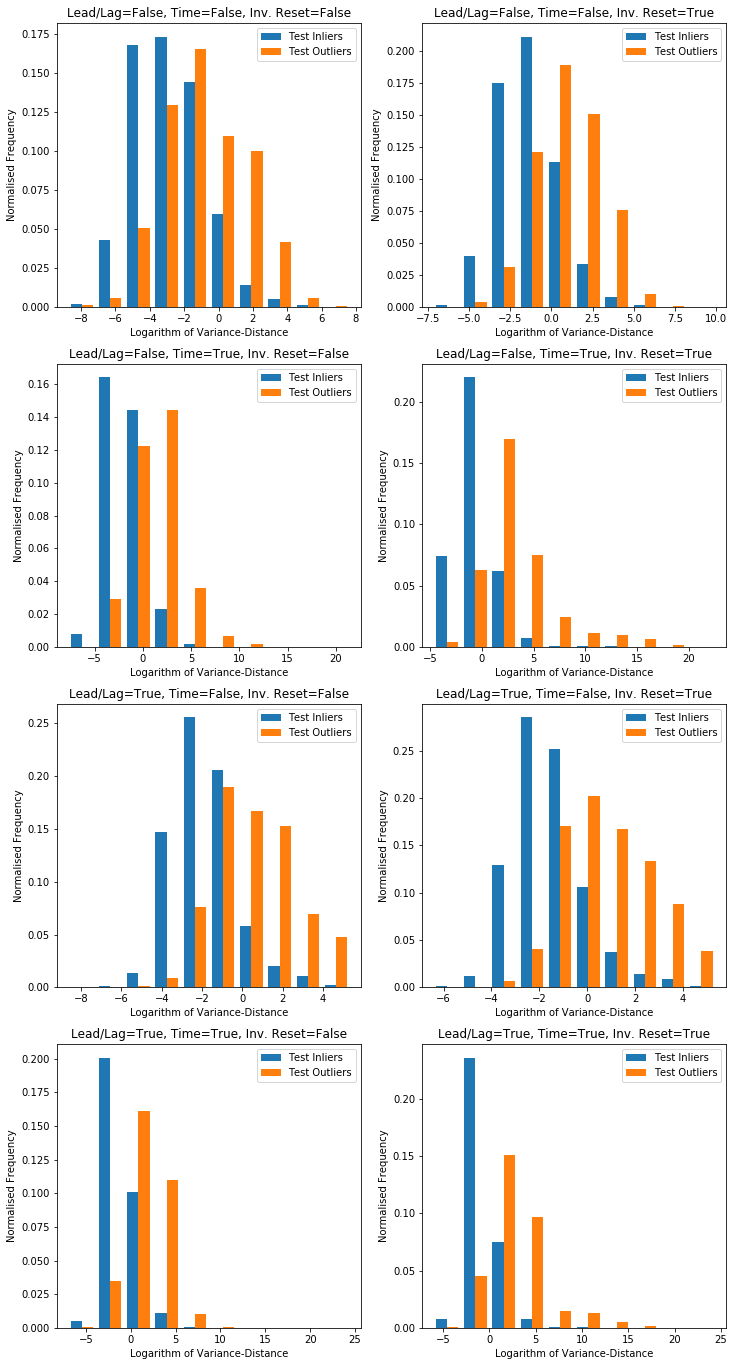

In [39]:
def plot_histogram_of_variance_by_class(variance_inliers, variance_outliers):
    n_subplots = len(variance_inliers)
    fig, axs = plt.subplots(n_subplots // 2, 2, figsize=(12, 6 * n_subplots // 2))
    for key, ax in zip(variance_inliers.keys(), axs.flatten()):
        ax.hist([np.log(variance_inliers[key] + np.spacing(0)),
                 np.log(variance_outliers[key] + np.spacing(0))], density=True,
                 label=['Test Inliers', 'Test Outliers'])
        ax.legend()
        ax.set_xlabel('Logarithm of Variance-Distance')
        ax.set_ylabel('Normalised Frequency')
        ax.set_title(key)
    plt.show()

plot_histogram_of_variance_by_class(variance_inliers_vs_hyperparams['Substreams using distance threshold 32000m'],
                                    variance_outliers_vs_hyperparams['Substreams using distance threshold 32000m'])

Plot ROC Curves across hyper-parameters:

Substreams using distance threshold 4000m


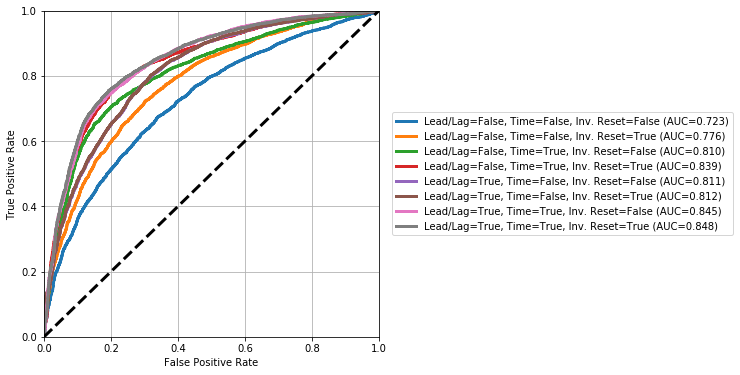

Substreams using distance threshold 8000m


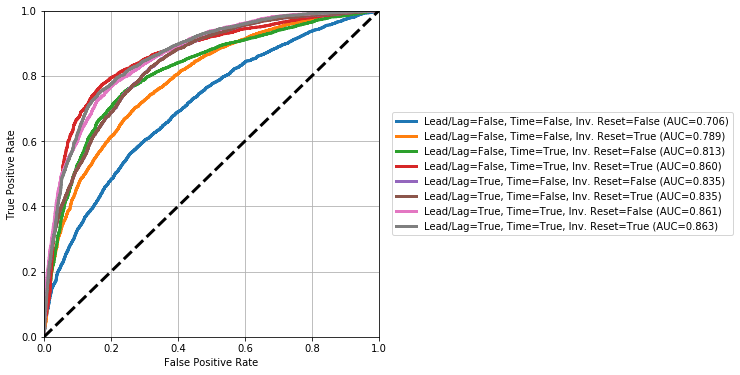

Substreams using distance threshold 16000m


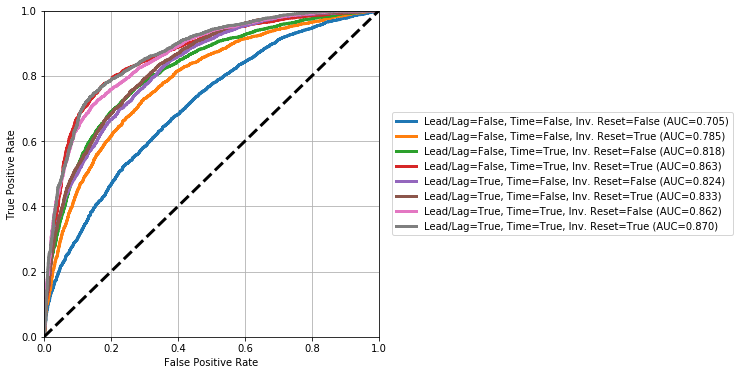

Substreams using distance threshold 32000m


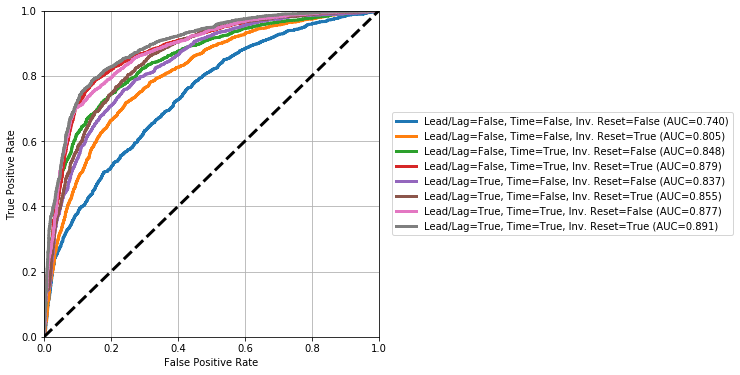

In [40]:
for key in variance_inliers_vs_hyperparams:
    print(key)
    evaluation.plot_roc_curve(variance_inliers_vs_hyperparams[key], variance_outliers_vs_hyperparams[key])

Tabulate AUC scores and bootstapped standard errors:

In [41]:
auc_vs_hyperparameters, standard_error_vs_hyperparameters = \
    evaluation.tabulate_performance(variance_inliers_vs_hyperparams, variance_outliers_vs_hyperparams)

In [42]:
auc_vs_hyperparameters

Substreams using distance threshold 4000m  \
Lead/Lag=False, Time=False, Inv. Reset=False                                     0.723   
Lead/Lag=False, Time=False, Inv. Reset=True                                      0.776   
Lead/Lag=False, Time=True, Inv. Reset=False                                      0.810   
Lead/Lag=False, Time=True, Inv. Reset=True                                       0.839   
Lead/Lag=True, Time=False, Inv. Reset=False                                      0.811   
Lead/Lag=True, Time=False, Inv. Reset=True                                       0.812   
Lead/Lag=True, Time=True, Inv. Reset=False                                       0.845   
Lead/Lag=True, Time=True, Inv. Reset=True                                        0.848   

                                             Substreams using distance threshold 8000m  \
Lead/Lag=False, Time=False, Inv. Reset=False                                     0.706   
Lead/Lag=False, Time=False, Inv. Reset=True                                      0.789   
Lead/Lag=False, Time=True, Inv. Reset=False                                      0.813   
Lead/Lag=False, Time=True, Inv. Reset=True                                       0.860   
Lead/Lag=True, Time=False, Inv. Reset=False                                      0.835   
Lead/Lag=True, Time=False, Inv. Reset=True                                       0.835   
Lead/Lag=True, Time=True, Inv. Reset=False                                       0.861   
Lead/Lag=True, Time=True, Inv. Reset=True                                        0.863   

                                             Substreams using distance threshold 16000m  \
Lead/Lag=False, Time=False, Inv. Reset=False                                      0.705   
Lead/Lag=False, Time=False, Inv. Reset=True                                       0.785   
Lead/Lag=False, Time=True, Inv. Reset=False                                       0.818   
Lead/Lag=False, Time=True, Inv. Reset=True                                        0.863   
Lead/Lag=True, Time=False, Inv. Reset=False                                       0.824   
Lead/Lag=True, Time=False, Inv. Reset=True                                        0.833   
Lead/Lag=True, Time=True, Inv. Reset=False                                        0.862   
Lead/Lag=True, Time=True, Inv. Reset=True                                         0.870   

                                             Substreams using distance threshold 32000m  
Lead/Lag=False, Time=False, Inv. Reset=False                                      0.740  
Lead/Lag=False, Time=False, Inv. Reset=True                                       0.805  
Lead/Lag=False, Time=True, Inv. Reset=False                                       0.848  
Lead/Lag=False, Time=True, Inv. Reset=True                                        0.879  
Lead/Lag=True, Time=False, Inv. Reset=False                                       0.837  
Lead/Lag=True, Time=False, Inv. Reset=True                                        0.855  
Lead/Lag=True, Time=True, Inv. Reset=False                                        0.877  
Lead/Lag=True, Time=True, Inv. Reset=True                                         0.891

In [43]:
standard_error_vs_hyperparameters

Substreams using distance threshold 4000m  \
Lead/Lag=False, Time=False, Inv. Reset=False                                     0.005   
Lead/Lag=False, Time=False, Inv. Reset=True                                      0.005   
Lead/Lag=False, Time=True, Inv. Reset=False                                      0.004   
Lead/Lag=False, Time=True, Inv. Reset=True                                       0.004   
Lead/Lag=True, Time=False, Inv. Reset=False                                      0.004   
Lead/Lag=True, Time=False, Inv. Reset=True                                       0.004   
Lead/Lag=True, Time=True, Inv. Reset=False                                       0.004   
Lead/Lag=True, Time=True, Inv. Reset=True                                        0.004   

                                             Substreams using distance threshold 8000m  \
Lead/Lag=False, Time=False, Inv. Reset=False                                     0.005   
Lead/Lag=False, Time=False, Inv. Reset=True                                      0.004   
Lead/Lag=False, Time=True, Inv. Reset=False                                      0.004   
Lead/Lag=False, Time=True, Inv. Reset=True                                       0.004   
Lead/Lag=True, Time=False, Inv. Reset=False                                      0.004   
Lead/Lag=True, Time=False, Inv. Reset=True                                       0.004   
Lead/Lag=True, Time=True, Inv. Reset=False                                       0.004   
Lead/Lag=True, Time=True, Inv. Reset=True                                        0.004   

                                             Substreams using distance threshold 16000m  \
Lead/Lag=False, Time=False, Inv. Reset=False                                      0.005   
Lead/Lag=False, Time=False, Inv. Reset=True                                       0.004   
Lead/Lag=False, Time=True, Inv. Reset=False                                       0.004   
Lead/Lag=False, Time=True, Inv. Reset=True                                        0.004   
Lead/Lag=True, Time=False, Inv. Reset=False                                       0.004   
Lead/Lag=True, Time=False, Inv. Reset=True                                        0.004   
Lead/Lag=True, Time=True, Inv. Reset=False                                        0.004   
Lead/Lag=True, Time=True, Inv. Reset=True                                         0.003   

                                             Substreams using distance threshold 32000m  
Lead/Lag=False, Time=False, Inv. Reset=False                                      0.005  
Lead/Lag=False, Time=False, Inv. Reset=True                                       0.004  
Lead/Lag=False, Time=True, Inv. Reset=False                                       0.004  
Lead/Lag=False, Time=True, Inv. Reset=True                                        0.004  
Lead/Lag=True, Time=False, Inv. Reset=False                                       0.004  
Lead/Lag=True, Time=False, Inv. Reset=True                                        0.004  
Lead/Lag=True, Time=True, Inv. Reset=False                                        0.003  
Lead/Lag=True, Time=True, Inv. Reset=True                                         0.003

Evaluate a baseline which uses sub-stream moments as features in combination with an isolation forest: 

In [44]:
def score_using_isolation_forest_based_on_moments(streams_by_inlier_vessel_train, streams_by_inlier_vessel_test,
                                                  streams_by_outlier_vessel, distance_threshold, signature_order=3):
    streams_by_inlier_vessel_train, minimum, maximum = normalise(streams_by_inlier_vessel_train)
    streams_by_inlier_vessel_test, *_ = normalise(streams_by_inlier_vessel_test, minimum, maximum)
    streams_by_outlier_vessel, *_ = normalise(sklearn.utils.shuffle(streams_by_outlier_vessel, random_state=0),
                                              minimum, maximum)
    def compute_moment_features(streams):
        features = []
        for stream in streams:
            mean = np.mean(stream, axis=0)
            cov = np.cov(stream, rowvar=False)[np.triu_indices(len(mean))]
            features.append(np.append(mean, np.ravel(cov)))
        return np.array(features)
    
    features_by_inlier_vessel_train, features_by_inlier_vessel_test, features_by_outlier_vessel = \
        map(compute_moment_features, (streams_by_inlier_vessel_train, streams_by_inlier_vessel_test,
                                      streams_by_outlier_vessel))
    
    detector = sklearn.ensemble.IsolationForest(random_state=0).fit(features_by_inlier_vessel_train)
    scores_inliers = -1 * detector.score_samples(features_by_inlier_vessel_test)
    scores_outliers = -1 * detector.score_samples(features_by_outlier_vessel)
    
    return scores_inliers, scores_outliers

variance_inliers_vs_hyperparams, variance_outliers_vs_hyperparams = \
    evaluate_across_hyperparams(outlier_detection_method=score_using_isolation_forest_based_on_moments)

Plot ROC Curves across hyper-parameters:

Substreams using distance threshold 4000m


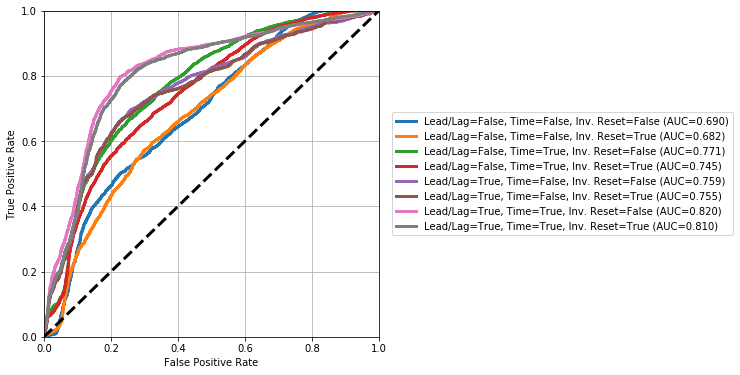

Substreams using distance threshold 8000m


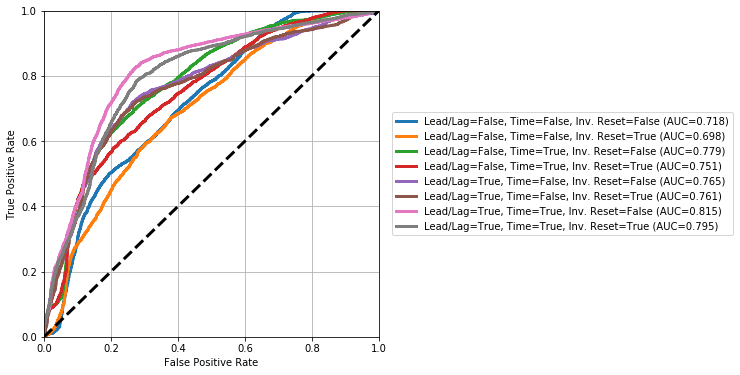

Substreams using distance threshold 16000m


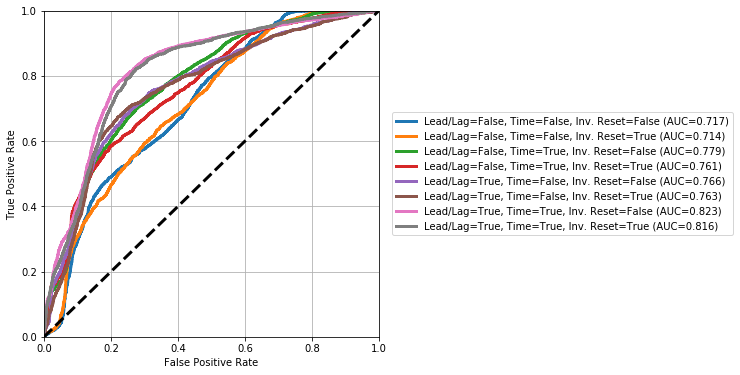

Substreams using distance threshold 32000m


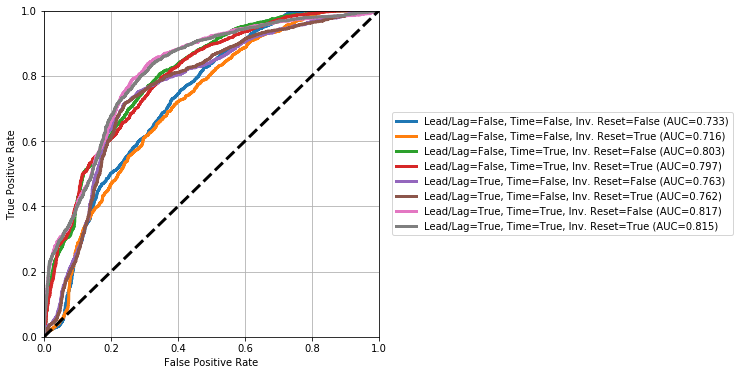

In [45]:
for key in variance_inliers_vs_hyperparams:
    print(key)
    evaluation.plot_roc_curve(variance_inliers_vs_hyperparams[key], variance_outliers_vs_hyperparams[key])

Tabulate AUC scores and bootstapped standard errors:

In [46]:
auc_vs_hyperparameters, standard_error_vs_hyperparameters = \
    evaluation.tabulate_performance(variance_inliers_vs_hyperparams, variance_outliers_vs_hyperparams)

In [47]:
auc_vs_hyperparameters

Substreams using distance threshold 4000m  \
Lead/Lag=False, Time=False, Inv. Reset=False                                     0.690   
Lead/Lag=False, Time=False, Inv. Reset=True                                      0.682   
Lead/Lag=False, Time=True, Inv. Reset=False                                      0.771   
Lead/Lag=False, Time=True, Inv. Reset=True                                       0.745   
Lead/Lag=True, Time=False, Inv. Reset=False                                      0.759   
Lead/Lag=True, Time=False, Inv. Reset=True                                       0.755   
Lead/Lag=True, Time=True, Inv. Reset=False                                       0.820   
Lead/Lag=True, Time=True, Inv. Reset=True                                        0.810   

                                             Substreams using distance threshold 8000m  \
Lead/Lag=False, Time=False, Inv. Reset=False                                     0.718   
Lead/Lag=False, Time=False, Inv. Reset=True                                      0.698   
Lead/Lag=False, Time=True, Inv. Reset=False                                      0.779   
Lead/Lag=False, Time=True, Inv. Reset=True                                       0.751   
Lead/Lag=True, Time=False, Inv. Reset=False                                      0.765   
Lead/Lag=True, Time=False, Inv. Reset=True                                       0.761   
Lead/Lag=True, Time=True, Inv. Reset=False                                       0.815   
Lead/Lag=True, Time=True, Inv. Reset=True                                        0.795   

                                             Substreams using distance threshold 16000m  \
Lead/Lag=False, Time=False, Inv. Reset=False                                      0.717   
Lead/Lag=False, Time=False, Inv. Reset=True                                       0.714   
Lead/Lag=False, Time=True, Inv. Reset=False                                       0.779   
Lead/Lag=False, Time=True, Inv. Reset=True                                        0.761   
Lead/Lag=True, Time=False, Inv. Reset=False                                       0.766   
Lead/Lag=True, Time=False, Inv. Reset=True                                        0.763   
Lead/Lag=True, Time=True, Inv. Reset=False                                        0.823   
Lead/Lag=True, Time=True, Inv. Reset=True                                         0.816   

                                             Substreams using distance threshold 32000m  
Lead/Lag=False, Time=False, Inv. Reset=False                                      0.733  
Lead/Lag=False, Time=False, Inv. Reset=True                                       0.716  
Lead/Lag=False, Time=True, Inv. Reset=False                                       0.803  
Lead/Lag=False, Time=True, Inv. Reset=True                                        0.797  
Lead/Lag=True, Time=False, Inv. Reset=False                                       0.763  
Lead/Lag=True, Time=False, Inv. Reset=True                                        0.762  
Lead/Lag=True, Time=True, Inv. Reset=False                                        0.817  
Lead/Lag=True, Time=True, Inv. Reset=True                                         0.815

In [48]:
standard_error_vs_hyperparameters

Substreams using distance threshold 4000m  \
Lead/Lag=False, Time=False, Inv. Reset=False                                     0.005   
Lead/Lag=False, Time=False, Inv. Reset=True                                      0.005   
Lead/Lag=False, Time=True, Inv. Reset=False                                      0.005   
Lead/Lag=False, Time=True, Inv. Reset=True                                       0.005   
Lead/Lag=True, Time=False, Inv. Reset=False                                      0.005   
Lead/Lag=True, Time=False, Inv. Reset=True                                       0.005   
Lead/Lag=True, Time=True, Inv. Reset=False                                       0.004   
Lead/Lag=True, Time=True, Inv. Reset=True                                        0.004   

                                             Substreams using distance threshold 8000m  \
Lead/Lag=False, Time=False, Inv. Reset=False                                     0.005   
Lead/Lag=False, Time=False, Inv. Reset=True                                      0.005   
Lead/Lag=False, Time=True, Inv. Reset=False                                      0.005   
Lead/Lag=False, Time=True, Inv. Reset=True                                       0.005   
Lead/Lag=True, Time=False, Inv. Reset=False                                      0.005   
Lead/Lag=True, Time=False, Inv. Reset=True                                       0.005   
Lead/Lag=True, Time=True, Inv. Reset=False                                       0.004   
Lead/Lag=True, Time=True, Inv. Reset=True                                        0.005   

                                             Substreams using distance threshold 16000m  \
Lead/Lag=False, Time=False, Inv. Reset=False                                      0.005   
Lead/Lag=False, Time=False, Inv. Reset=True                                       0.005   
Lead/Lag=False, Time=True, Inv. Reset=False                                       0.005   
Lead/Lag=False, Time=True, Inv. Reset=True                                        0.005   
Lead/Lag=True, Time=False, Inv. Reset=False                                       0.005   
Lead/Lag=True, Time=False, Inv. Reset=True                                        0.005   
Lead/Lag=True, Time=True, Inv. Reset=False                                        0.004   
Lead/Lag=True, Time=True, Inv. Reset=True                                         0.004   

                                             Substreams using distance threshold 32000m  
Lead/Lag=False, Time=False, Inv. Reset=False                                      0.005  
Lead/Lag=False, Time=False, Inv. Reset=True                                       0.005  
Lead/Lag=False, Time=True, Inv. Reset=False                                       0.004  
Lead/Lag=False, Time=True, Inv. Reset=True                                        0.004  
Lead/Lag=True, Time=False, Inv. Reset=False                                       0.005  
Lead/Lag=True, Time=False, Inv. Reset=True                                        0.005  
Lead/Lag=True, Time=True, Inv. Reset=False                                        0.004  
Lead/Lag=True, Time=True, Inv. Reset=True                                         0.004

In [49]:
print('Execution time (s): {:.1f}'.format(time.time() - t0))

Execution time (s): 42098.5
